# EOBS seasonal means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask
import intake
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from warnings import warn
import cordex as cx
import cf_xarray as cfxr
import xesmf as xe

from evaltools.source import get_source_collection, open_and_sort


dask.config.set(scheduler="single-threaded")

In [3]:
cx.__version__

'0.9.0.post1.dev10+g9cb220b.d20241219'

In [4]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38197,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:43177,Total threads: 1
Dashboard: http://127.0.0.1:37673/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:46449,


In [5]:
def add_bounds(ds):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=("vertices_lon", "vertices_lat"))
        #ds["vertices_lon"].attrs = {}
        #ds["vertices_lat"].attrs = {}
        #ds[ds.cf["longitude"].name].attrs["bounds"] = "vertices_lon"
        #ds[ds.cf["latitude"].name].attrs["bounds"] = "vertices_lat"
    #ds["vertices_lon"].attrs = {}
    #ds["vertices_lat"].attrs = {}
    # reorder vertices to be counterclockwise for xesmf
    ds['lon_b'] = cfxr.bounds_to_vertices(
        ds.vertices_lon, bounds_dim="vertices", order="counterclockwise"
    )
    ds['lat_b'] = cfxr.bounds_to_vertices(
        ds.vertices_lat, bounds_dim="vertices", order="counterclockwise")
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        warn(f"sftlf not found in dataset: {ds.source_id}")
    return ds


def open_datasets(variables, frequency="mon", mask=True, add_missing_bounds=True):
    catalog = get_source_collection(variables, frequency, add_fx=["areacella", "sftlf"])
    dsets = open_and_sort(catalog, merge=True)
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for ds in dsets.values():
            ds = add_bounds(ds)
    return dsets


def create_cordex_grid(domain_id):
    grid = cx.domain(domain_id, bounds=True, mip_era="CMIP6")
    #grid["lon"].attrs = {}
    #grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid.vertices_lon, bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid.vertices_lat, bounds_dim="vertices", order="counterclockwise")
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in  ["mask", "sftlf"]:
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"]>0.)
    return ds_regrid

def regrid_dsets(dsets, target_grid):
    for dset_id, ds in dsets.items():
        print(dset_id)
        mapping = ds.cf["grid_mapping"].grid_mapping_name
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets



In [6]:
dsets = open_datasets(["tas"], frequency="mon")

Found: ['HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020'] for variables: ['tas']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarr

Found 11 datasets
merging: CORDEX.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.v20240920
merging: CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.v20241120
merging: CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205
merging: CORDEX.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.v20241216


In [184]:
'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'.split(".") 

['project_id',
 'domain_id',
 'institution_id',
 'driving_source_id',
 'driving_experiment_id',
 'driving_variant_label',
 'source_id',
 'version_realization',
 'frequency',
 'variable_id',
 'version']

In [7]:
rotated_grid = create_cordex_grid("EUR-11")
dsets = regrid_dsets(dsets, rotated_grid)

CORDEX.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.v20240920
CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.v20241120
CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205
regridding CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205 with grid_mapping: lambert_conformal_conic
CORDEX.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.v20241216


In [143]:
eobs = obs.eobs(add_mask=False)
regridder = xe.Regridder(eobs, rotated_grid, method="bilinear", unmapped_to_nan=True)
eobs_on_rotated = regridder(eobs)

In [150]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)

In [147]:
import numpy as np
import xarray as xr

xr.DataArray(np.array([np.nan, np.nan, np.nan, np.nan]), dims="x").sum("x", skipna=True, min_count=1)

<xarray.DataArray ()> Size: 8B
array(nan)

In [151]:
%%time

period = slice("1980", "2020")
eobs_seasmean = seasonal_mean(eobs_on_rotated.tg.sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 16.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 11 s, sys: 1.6 s, total: 12.6 s
Wall time: 33.6 s


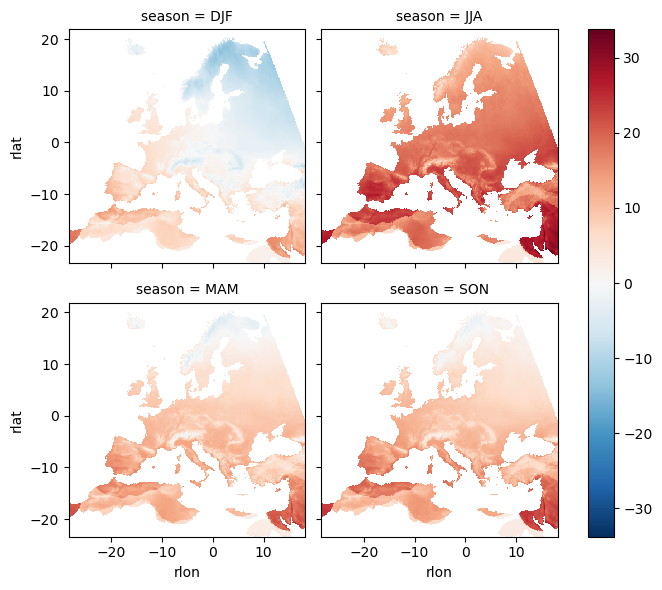

In [154]:
eobs_seasmean.plot(col="season", col_wrap=2)

In [201]:
variable = "tas"

from evaltools.utils import short_iid, iid_to_dict, dict_to_iid


diffs = {dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute() - (eobs_seasmean + 273.5) for dset_id, ds in dsets.items()}
seasonal_bias = xr.concat(list(diffs.values()), dim=xr.DataArray(list(map(short_iid, diffs.keys())), dims="dset_id"), compat="override", coords="minimal")

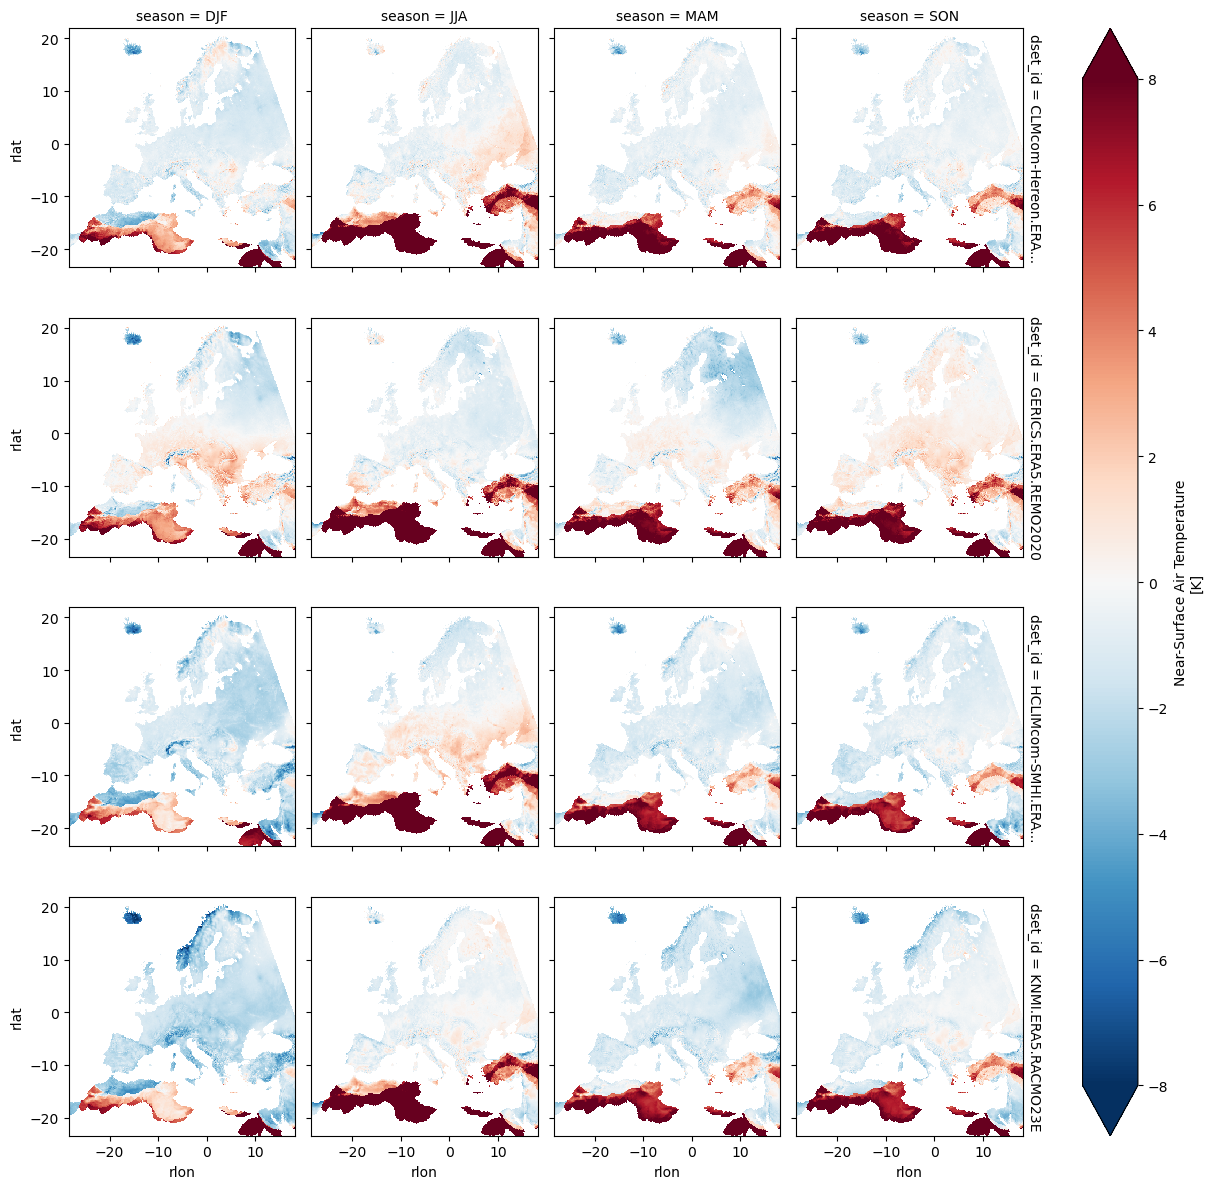

In [202]:
seasonal_bias.tas.plot(col="season", row="dset_id", vmin=-8, vmax=8, cmap="RdBu_r")

In [204]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

ds = seasonal_bias

# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = ds.season.size
Cols = ds.dset_id.size
# Compute Rows required
Rows = Tot // Cols
Rows += Tot % Cols
# Create a Position index
Position = range(1, Tot + 1)

In [212]:
ds#.cf["grid_mapping"]

<xarray.Dataset> Size: 26MB
Dimensions:    (dset_id: 4, season: 4, rlat: 412, rlon: 424)
Coordinates:
  * rlat       (rlat) float64 3kB -23.38 -23.27 -23.16 ... 21.61 21.73 21.84
  * rlon       (rlon) float64 3kB -28.38 -28.27 -28.16 ... 17.93 18.05 18.16
    lat        (rlat, rlon) float64 1MB 21.99 22.03 22.07 ... 66.81 66.75 66.69
    lon        (rlat, rlon) float64 1MB -10.06 -9.964 -9.864 ... 64.76 64.96
    areacella  (rlat, rlon) float32 699kB 1.373e+08 1.373e+08 ... 1.389e+08
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * dset_id    (dset_id) <U38 608B 'CLMcom-Hereon.ERA5.ICON-CLM-202407-1-1' ....
Data variables:
    tas        (dset_id, season, rlat, rlon) float64 22MB nan nan ... nan nan
Attributes: (12/50)
    CDO:                                     Climate Data Operators version 2...
    Conventions:                             CF-1.11
    activity_id:                             DD
    contact:                                 iconclm@dwd.de
    creation_date:                           2024-11-21T10:39:42Z
    domain:                                  Europe
    ...                                      ...
    intake_esm_attrs:frequency:              fx
    intake_esm_attrs:version:                v20240920
    intake_esm_attrs:variable_id:            areacella
    intake_esm_attrs:path:                   /mnt/CORDEX_CMIP6_tmp/sim_data/C...
    intake_esm_attrs:_data_format_:          netcdf
    intake_esm_dataset_key:                  CORDEX.EUR-12.CLMcom-Hereon.ERA5...

0 DJF CLMcom-Hereon.ERA5.ICON-CLM-202407-1-1
4 DJF GERICS.ERA5.REMO2020
8 DJF HCLIMcom-SMHI.ERA5.HCLIM43-ALADIN
12 DJF KNMI.ERA5.RACMO23E
1 JJA CLMcom-Hereon.ERA5.ICON-CLM-202407-1-1
5 JJA GERICS.ERA5.REMO2020
9 JJA HCLIMcom-SMHI.ERA5.HCLIM43-ALADIN
13 JJA KNMI.ERA5.RACMO23E
2 MAM CLMcom-Hereon.ERA5.ICON-CLM-202407-1-1
6 MAM GERICS.ERA5.REMO2020
10 MAM HCLIMcom-SMHI.ERA5.HCLIM43-ALADIN
14 MAM KNMI.ERA5.RACMO23E
3 SON CLMcom-Hereon.ERA5.ICON-CLM-202407-1-1
7 SON GERICS.ERA5.REMO2020
11 SON HCLIMcom-SMHI.ERA5.HCLIM43-ALADIN
15 SON KNMI.ERA5.RACMO23E


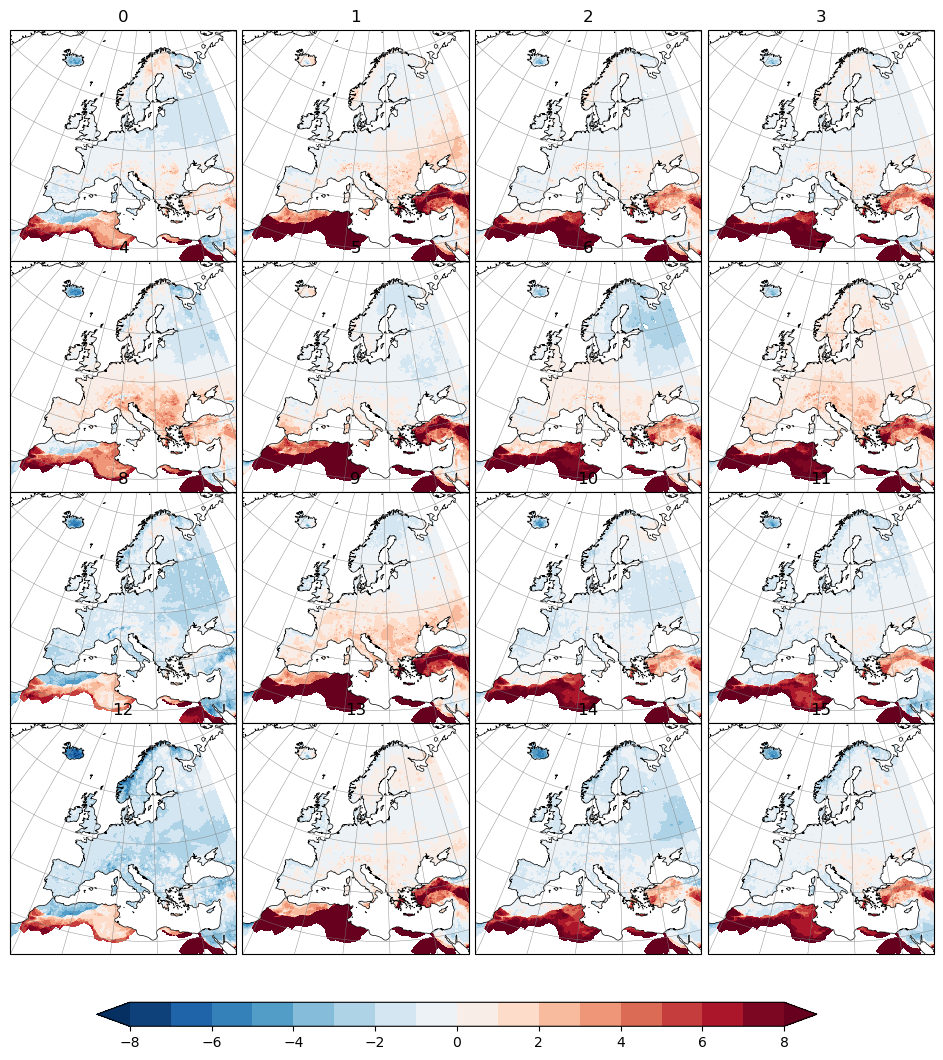

In [244]:
ds = seasonal_bias

nrows = ds.dset_id.size
ncols = ds.season.size

#ds = diffs.where(~diffs.isnull(), drop=True)
tas = ds.tas
#pole = ds.cf["grid_mapping"]
#transform = ccrs.RotatedPole(
#    pole_latitude=pole.grid_north_pole_latitude,
#    pole_longitude=pole.grid_north_pole_longitude,
#)
transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.)
projection = transform

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": projection},
    figsize=(12, 12),
    sharex=True,
    sharey=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# Loop over all of the models
for i, season in enumerate(ds.season.values):
    for j, dset_id in enumerate(ds.dset_id.values):
        pos = i + j * ncols
        print(pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds.tas.isel(season=i, dset_id=j)

        # Add the cyclic point
        # data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels = np.arange(-8, 9, 1),
            #cmap="coolwarm",
            extend="both",
            #vmin=-8, vmax=8,
            cmap="RdBu_r",
        )

        axs[pos].set_aspect('equal')

        # Title each subplot with the name of the model
        axs[pos].set_title(pos)

        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

        axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
            
        )
        #axs[pos].xaxis.set_tick_position('bottom')
        #axs[pos].yaxis.set_tick_position('left')

        # Longitude labels
        #if j == 0:
        #    axs[pos].set_xlabel(dset_id)
        #    axs[pos].set_xticks(range(-180, 180, 10), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)

        # # Latitude labels
        #axs[pos].set_yticks(range(-90, 90, 10), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # axs[i].yaxis.set_major_formatter(lat_formatter)

#plt.subplots_adjust(wspace=0, hspace=0)

# Adjust the location of the subplots on the page to make room for the colorbar
#fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.08, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal")

# Add a big title at the top
# plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')

In [84]:
dsets["CORDEX.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.v20240920"]

<xarray.Dataset> Size: 371MB
Dimensions:                     (rlat: 412, rlon: 424, time: 504, bnds: 2,
                                 vertices: 4, rlat_vertices: 413,
                                 rlon_vertices: 425)
Coordinates: (12/13)
  * rlat                        (rlat) float64 3kB -23.38 -23.27 ... 21.73 21.84
  * rlon                        (rlon) float64 3kB -28.38 -28.27 ... 18.05 18.16
  * time                        (time) object 4kB 1979-01-16 12:00:00 ... 202...
    rlat_bnds                   (rlat, bnds) float64 7kB -23.43 -23.32 ... 21.89
    rlon_bnds                   (rlon, bnds) float64 7kB -28.43 -28.32 ... 18.21
    rotated_latitude_longitude  int32 4B -2147483647
    ...                          ...
    lon                         (rlat, rlon) float64 1MB -10.06 -9.964 ... 64.96
    vertices_lat                (rlat, rlon, vertices) float64 6MB 21.92 ... ...
    vertices_lon                (rlat, rlon, vertices) float64 6MB -10.09 ......
    areacella                   (rlat, rlon) float32 699kB 1.373e+08 ... 1.38...
    time_bnds                   (time, bnds) object 8kB 1979-01-01 00:00:00 ....
    height                      float64 8B 2.0
Dimensions without coordinates: bnds, vertices, rlat_vertices, rlon_vertices
Data variables:
    sftlf                       (rlat, rlon) float32 699kB 100.0 100.0 ... 100.0
    tas                         (time, rlat, rlon) float32 352MB 293.0 ... 255.4
    mask                        (rlat, rlon) bool 175kB True True ... True True
    lon_b                       (rlat_vertices, rlon_vertices) float64 1MB -1...
    lat_b                       (rlat_vertices, rlon_vertices) float64 1MB 21...
Attributes: (12/50)
    CDO:                                     Climate Data Operators version 2...
    Conventions:                             CF-1.11
    activity_id:                             DD
    contact:                                 iconclm@dwd.de
    creation_date:                           2024-11-21T10:39:42Z
    domain:                                  Europe
    ...                                      ...
    intake_esm_attrs:frequency:              fx
    intake_esm_attrs:version:                v20240920
    intake_esm_attrs:variable_id:            areacella
    intake_esm_attrs:path:                   /mnt/CORDEX_CMIP6_tmp/sim_data/C...
    intake_esm_attrs:_data_format_:          netcdf
    intake_esm_dataset_key:                  CORDEX.EUR-12.CLMcom-Hereon.ERA5...

In [213]:
cx.domain("EUR-11")

<xarray.Dataset> Size: 3MB
Dimensions:                     (rlon: 424, rlat: 412)
Coordinates:
  * rlon                        (rlon) float64 3kB -28.38 -28.27 ... 18.05 18.16
  * rlat                        (rlat) float64 3kB -23.38 -23.27 ... 21.73 21.84
    lon                         (rlat, rlon) float64 1MB -10.06 -9.964 ... 64.96
    lat                         (rlat, rlon) float64 1MB 21.99 22.03 ... 66.69
Data variables:
    rotated_latitude_longitude  int32 4B 0
Attributes:
    CORDEX_domain:  EUR-11